# Machine learning applications

This week we will develop machine learning models for two common supervised learning tasks in Earth Science: 

1) Image classification

2) Time-series prediction

Initially, we will approach these tasks by converting the image pixels and time-series data into structured datasets (i.e. organized into a table with rows and columns). This means that we will be considering each pixel or data point to be an **independent** observation. This assumption will allow us to apply conventional machine learning algorithms (e.g. Random Forests) and get some decent results. 

However, we will discover that there probably are **spatial dependencies** in the **image pixels** and **temporal dependencies** in the **time-series data**. So, in the second part of the lecture, we will introduce another class of machine learning algorithms called **neural networks** which are extremely flexible and can be designed to exploit these dependencies for better predictions.   

## Image classification

The data we will be using is a **SkySat** image over the western Greenland Ice Sheet acquired in June 2019. The SkySat-C constellation which consists of nineteen SmallSats (110 kg) launched between 2016 and 2020 and operated by Planet (formerly Planet Labs, Inc). Each SkySat satellite has a multispectral camera that can acquire imagery with four bands (i.e. blue, green, red, and NIR) with a spatial resolution of <1 m.

```{image} images/skysat.png
:width: 600px
:align: center
```

## Read data

Let's open a single band from the image using the `read()` function and have a look at it. 

```{note}
Bands are indexed from 1 due to a  GDAL convention.
```

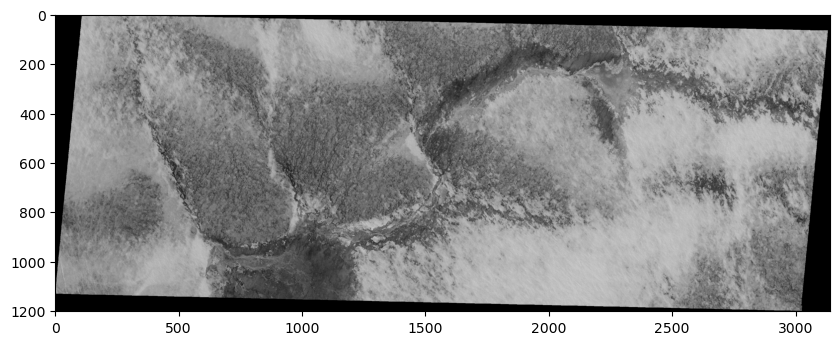

In [78]:
# Import packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import rasterio
import numpy as np

# Open raster
src = rasterio.open('data/20190619_175047_ssc10d1_0023_pansharpened.tif')

# Read band
band_4 = src.read(4)

# Plot band
fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(band_1, cmap='gray')
plt.show()

In [10]:
print(src.count)

4


## True color SkySat image

We notice that our image has a `count` of **4** which means that our image has **4** different **bands**, each of which represent the reflectance in a **specific wavelength**. Since our SkySat data contains multiple bands, we can visualize a "true color" image that combines the red, green, and blue bands to make an image similar to what the human eye would observe. 

To do this, we will read the other two bands, stack them, and pass this 3-band array to [`imshow`](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html).

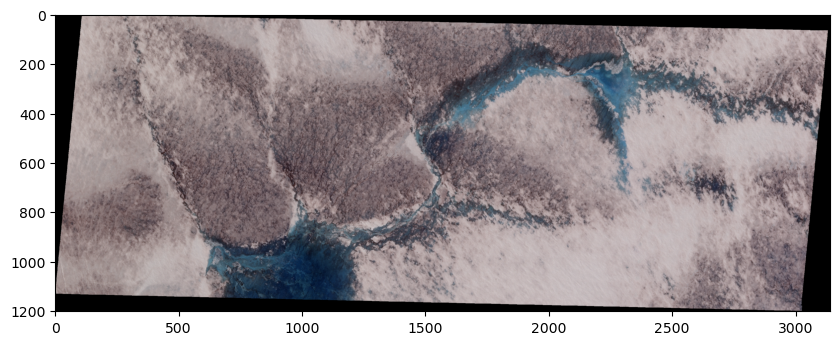

In [13]:
# Read other bands
band_1 = src.read(1)
band_2 = src.read(2)
band_3 = src.read(3)

# Produce a new array by stacking the RGB bands
rgb = np.dstack((band_3, band_2, band_1))

# Plot as RGB image
fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(rgb)
plt.show()

## Import training dataset

The training dataset for this **supervised classification** task was digitized using QGIS. To construct the training dataset, we drew polygons around pixels that represented specific land cover classes using QGIS. We then sampled pixel values beneath the polygons and converted these values into a table. 

```{important}
Each row in the training data represents a single pixel.
```

In [15]:
# Import packages
import pandas as pd

# Import training dataset
training_data = pd.read_csv('data/training-dataset.csv')
training_data.head()

,band1,band2,band3,band4,labels
0,175,175,175,175,1
1,176,176,176,176,1
2,177,177,177,177,1
3,180,180,180,180,1
4,178,178,178,178,1


## Explore training dataset

The first goal of any machine learning task should be develop some intuition about our training data. The following information will be very useful:

In [16]:
# Number of classes
training_data['labels'].unique()

array([1, 2])

```{note}
These numeric values correspond to the following classes.
```

In [17]:
# Define class labels
class_labels = ['ice', 'water']

In [18]:
# The number of samples and their data type
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18184 entries, 0 to 18183
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   band1   18184 non-null  int64
 1   band2   18184 non-null  int64
 2   band3   18184 non-null  int64
 3   band4   18184 non-null  int64
 4   labels  18184 non-null  int64
dtypes: int64(5)
memory usage: 710.4 KB


In [19]:
# The number of samples in each class
training_data["labels"].value_counts()

labels
1    11948
2     6236
Name: count, dtype: int64

In [20]:
# Mean value of each predictor by class
training_data.groupby('labels').mean()

,band1,band2,band3,band4
labels,,,,
1,135.788919,135.788919,135.788919,135.788919
2,50.293137,50.293137,50.293137,50.293137


In [21]:
# Statistics for each feature
training_data.describe()

,band1,band2,band3,band4,labels
count,18184.000000,18184.000000,18184.000000,18184.000000,18184.000000
mean,106.469094,106.469094,106.469094,106.469094,1.342939
std,56.379966,56.379966,56.379966,56.379966,0.474704
min,2.000000,2.000000,2.000000,2.000000,1.000000
25%,68.000000,68.000000,68.000000,68.000000,1.000000
50%,111.000000,111.000000,111.000000,111.000000,1.000000
75%,153.000000,153.000000,153.000000,153.000000,2.000000
max,206.000000,206.000000,206.000000,206.000000,2.000000


## Scale features

Even if it might not that much for some classifiers, it's good practice to scale our features. 

In [22]:
from sklearn.preprocessing import StandardScaler

# Define feature list
feature_list =  ['band1', 'band2', 'band3', 'band4']

# Define features and labels 
X = training_data[feature_list]
y = training_data['labels']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_list)
X_scaled.describe()

,band1,band2,band3,band4
count,1.818400e+04,1.818400e+04,1.818400e+04,1.818400e+04
mean,-2.500810e-17,-2.500810e-17,-2.500810e-17,-2.500810e-17
std,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00
min,-1.852998e+00,-1.852998e+00,-1.852998e+00,-1.852998e+00
25%,-6.823373e-01,-6.823373e-01,-6.823373e-01,-6.823373e-01
50%,8.036597e-02,8.036597e-02,8.036597e-02,8.036597e-02
75%,8.253319e-01,8.253319e-01,8.253319e-01,8.253319e-01
max,1.765408e+00,1.765408e+00,1.765408e+00,1.765408e+00


# Fit model

Now that our training data is scaled, we can fit our classifier. We will start with a `RandomForestClassifier` and use **"out-of-bag" scoring** to evaluate the model's performance on unseen data without requiring us to generate a separate validation dataset. 

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Define model
bclf = RandomForestClassifier(n_estimators=100, oob_score=True)

# Fit
bclf.fit(X_scaled, y)

#Print score
print(bclf.oob_score_)

0.9031016278046634


# Evaluate

We can predict the class probabilities for the "out-of-bag" samples using the `oob_decision_function_`. Once we have those predictions, we can compare them to the actual class values and generate a confusion matrix.

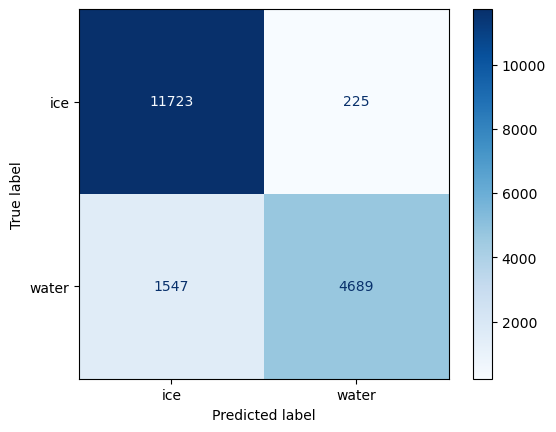

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# OOB predictions
y_pred = bclf.oob_decision_function_.argmax(axis=1) + 1

# Generate confusion matrix
cm = confusion_matrix(y, y_pred, labels=bclf.classes_)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Confusion matrix

There is a lot of information that can be understood from a confusion matrix, even though it only contains four numbers for a binary classification.

The **in-diagonal** numbers are **correct predictions** while **off-diagonal** numbers are **mispredictions**. Since we are interested in the amount of **water** in the satellite image, we will consider **water to be positive** and **ice to be negative**. 

* the top left corner therefore represents **true negative (TN)** that correspond **ice** pixels correctly classified as ice by the classifer.

* the bottom right corner represents **true positives (TP)** that correspond **water** pixels correctly classified as water by the classifer.

* the top right corner represents **false positives (FP)**, corresponding to ice pixels that what incorrectly classified as water.

* the bottom left corner are **false negatives (FN)**, corresponding to the water pixels that were incorrectly classified as ice.

Once we have split this information, we can compute metrics to investigate the generalization performance of our classifier in a particular setting. For instance, if our goal is to estimate the amount of water in the image, we might prefer to provide a lower-bound so we make statements such as "waters covers at least X% of the ice sheet". This statement is a stronger scientific argument than "water covers up to X% of the ice sheet" which implies that it could also cover 0%. 

The former metric, known as the **precision**, is defined as `TP / (TP + FP)` and represents how likely our classifier predicted water when it actually was. 

In [32]:
from sklearn.metrics import precision_score

precision = precision_score(y, y_pred)
print(f"Precision: {precision:.2f}")

Precision: 0.88


The other metic, known as the **recall**, defined as `TP / (TP + FN)` assesses how well our classifier was able to find all relevant instances of water.

In [35]:
from sklearn.metrics import recall_score

recall = recall_score(y, y_pred)
print(f"Recall: {recall:.2f}")

Recall: 0.98


The **higher recall** signifies that our classifier is good at finding all the water pixels, but the **lower precisions** indicates that it is incorrectly classifying a lot of ice pixels as water. Hence our classifier is probably providing an upper-bound on water coverage which is not really what we want. 

The best way to improve the precision in this case would be to update our training dataset, perhaps providing more edge cases of ice.  

## Classify whole image

Since this is just a demonstration, we will keep moving towards the goal of our analysis which is to classify every pixel in our SkySat image so that we can compute the total water coverage. 

In [37]:
# Convert 2D array to dictionary
band_data = {f"band_{b}": src.read(b).ravel() for b in range(1, src.count + 1)}

# Format as DataFrame
df = pd.DataFrame(band_data)

# Scale
X_scaled = scaler.fit_transform(df)
X_scaled = pd.DataFrame(X_scaled, columns=feature_list)

# Predict
y_pred = bclf.predict(X_scaled)

# Add predicted labels as column
df['labels'] = y_pred

# Set labels to zero where values in band 1 are equal to zero
df.loc[df['band_1'] == 0, 'labels'] = 0

# Reshape back to original size
y_pred_2d = df['labels'].values.reshape(src.shape)

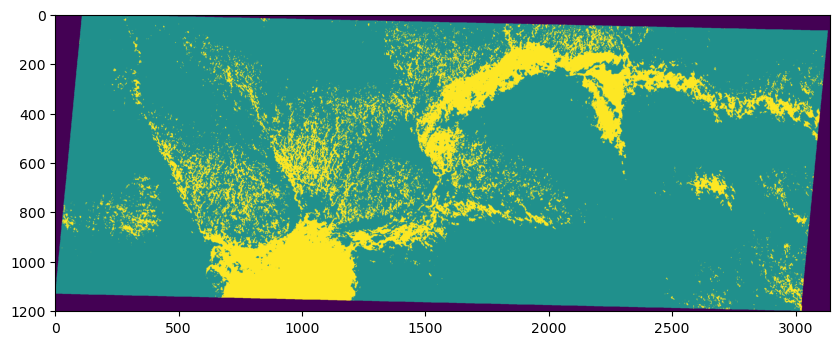

In [39]:
# Plot the classified image
plt.figure(figsize=(10, 6))
im = plt.imshow(y_pred_2d, vmin=0, vmax=2)

plt.show()

In [47]:
# Calculate water coverage
water_coverage = np.sum(y_pred_2d == 2) / np.sum(y_pred_2d > 0)
print(f"Water coverage is {water_coverage*100:.2f} %")

Water coverage is 16.31 %


## River discharge prediction

Our next example is a regression task to predict river discharge from climate data. We have nine years of discharge data from the Nisqually River, WA which is glacier-fed river that drains the southern slope of Mount Rainier. 

```{image} images/nisqually.png
:width: 600px
:align: center
```

We also have climate data from an automated Snow Telemetry (SNOTEL) monitoring site at Paradise. Our goal is to develop a model that learns to predict discharge from climate data. This could be useful if our discharge monitoring station was destroyed by a forest fire or flood. So we will train the model on paired climate-discharge data for 2013-2020 period, and test the model's ability to predict discharge for 2021.

```{image} images/snotel.png
:width: 600px
:align: center
```

In [69]:
# Read data
df = pd.read_csv('data/nisqually.csv', parse_dates=['Date'], index_col=['Date'])
df.head()

,Precipitation Increment (in),Air Temperature Average (degF),Air Temperature Minimum (degF),Air Temperature Maximum (degF),Soil Moisture Percent -2in (pct) Start of Day Values,Soil Moisture Percent -4in (pct) Start of Day Values,Soil Moisture Percent -8in (pct) Start of Day Values,Soil Moisture Percent -20in (pct) Start of Day Values,Snow Water Equivalent (in) Start of Day Values,Nisqually Discharge
Date,,,,,,,,,,
2013-01-01,0.0,30.0,21.0,36.0,26.2,25.0,34.0,34.9,34.9,424.0
2013-01-02,0.0,34.0,29.0,47.0,26.4,24.9,33.9,34.9,34.9,413.0
2013-01-03,0.1,35.0,31.0,46.0,26.2,25.1,34.0,35.0,35.0,404.0
2013-01-04,0.3,33.0,32.0,38.0,26.0,24.9,34.0,34.9,35.5,423.0
2013-01-05,0.4,33.0,28.0,39.0,26.1,24.7,34.0,34.9,35.8,426.0


## Explore training dataset

<Axes: ylabel='Discharge (cfs)'>

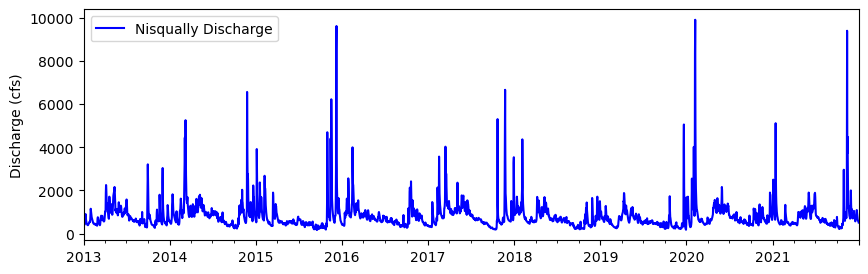

In [70]:
# Plot 2012-2021
df.plot(y='Nisqually Discharge', kind ='line', figsize=(10,3), ylabel='Discharge (cfs)', \
        xlabel="", color='blue')

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3287 entries, 2013-01-01 to 2021-12-31
Data columns (total 10 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Precipitation Increment (in)                           3287 non-null   float64
 1   Air Temperature Average (degF)                         3287 non-null   float64
 2   Air Temperature Minimum (degF)                         3287 non-null   float64
 3   Air Temperature Maximum (degF)                         3287 non-null   float64
 4   Soil Moisture Percent -2in (pct) Start of Day Values   3287 non-null   float64
 5   Soil Moisture Percent -4in (pct) Start of Day Values   3287 non-null   float64
 6   Soil Moisture Percent -8in (pct) Start of Day Values   3287 non-null   float64
 7   Soil Moisture Percent -20in (pct) Start of Day Values  3287 non-null   float64
 8   Snow Water Equivalent (in) Sta

In [72]:
# Compute correlation matrix
corr_matrix = df.corr()

# Display just house value correlations
corr_matrix["Nisqually Discharge"].sort_values(ascending= False)

Nisqually Discharge                                      1.000000
Precipitation Increment (in)                             0.373453
Soil Moisture Percent -2in (pct) Start of Day Values     0.336094
Soil Moisture Percent -4in (pct) Start of Day Values     0.313913
Soil Moisture Percent -8in (pct) Start of Day Values     0.267208
Soil Moisture Percent -20in (pct) Start of Day Values    0.253598
Snow Water Equivalent (in) Start of Day Values           0.237221
Air Temperature Minimum (degF)                          -0.097973
Air Temperature Average (degF)                          -0.108051
Air Temperature Maximum (degF)                          -0.129813
Name: Nisqually Discharge, dtype: float64

In [82]:
# Define start and end
start = '2021-01-01'
end = '2021-12-31'

# Define feature list
feature_list =  df.columns.to_list()[:-1]

## Scale features

In [83]:
X = df[feature_list]
y = df['Nisqually Discharge']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.index = X.index

## Split training and testing data

In [84]:
# Split data 
X_train = X_scaled[:start]
X_test = X_scaled[start:end]
y_train = y[:start]
y_test = y[start:end]

## Fit model

In [85]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Define model
model = HistGradientBoostingRegressor(max_iter=100)

# Fit model
model.fit(X_train, y_train)

# Predict test labels predictions
predictions = model.predict(X_test)

# Compute Nash–Sutcliffe efficiency (NSE)
nse = 1 - np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
print(f"NSE: {nse:.2f}")

NSE: 0.56


# Plot

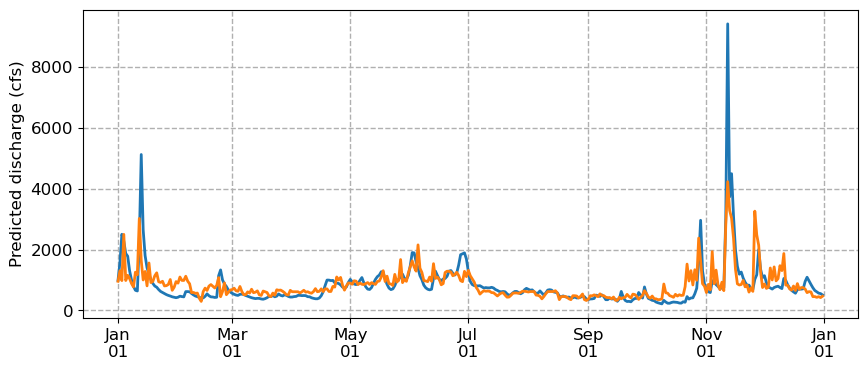

In [87]:
# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['2021-01-01':'2021-12-31'].index, df['Nisqually Discharge']['2021-01-01':'2021-12-31'], lw=2, zorder=3)
ax.plot(y_test.index, predictions, lw=2, zorder=3)
ax.set_ylabel('Predicted discharge (cfs)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%d'))

We notice that the predicted discharge captures general patterns from high to low to high again. But it's missing peaks in the discharge and it's a also a little jagged, likely because it treats observations as independent. We are approaching the limits of conventional machine learning algorithms which cannot explicitly model temporal dependencies. For that, we need a different approach: neural networks.